# Plants Seeding Classification Project_GAP

By: Glen A Patterson

Date: 02-20-2023

## Problem Statment:

Technological innovations in Artificial Intelligence can benefit the workers in this field of plant classification, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

## Objective:

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species.  As a data scientist, we need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

## Data Dictionary:

This dataset contains images of unique plants belonging to 12 different species.

The data file names are:

images.npy

Label.csv


**List of Plant species**

Black-grass

Charlock

Cleavers

Common Chickweed

Common Wheat

Fat Hen

Loose Silky-bent

Maize

Scentless Mayweed

Shepherds Purse

Small-flowered Cranesbill

Sugar beet

The goal of the project is to create a classifier capable of determining a plant's species from an image.

## Importing the necessary libraries:

In [1]:
# Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math  # Importing math module to perform mathematical operations
#!pip install opencv-python
import cv2  

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  

# Keras Sequential Model
from tensorflow.keras.models import Sequential

# Importing all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix  

# The below code can be used to ignore the warnings that may occur due to deprecations
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the images and labels
images=np.load('images.npy')
labels=pd.read_csv('Labels.csv')

In [3]:
# shape of the images and labels
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


- There are 4750 images with shape of 128,128,3

In [4]:
# The proportion of each class
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

## Exploratory Data Analysis

In [5]:
# function to plot images with labels
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 4                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(15, 15))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

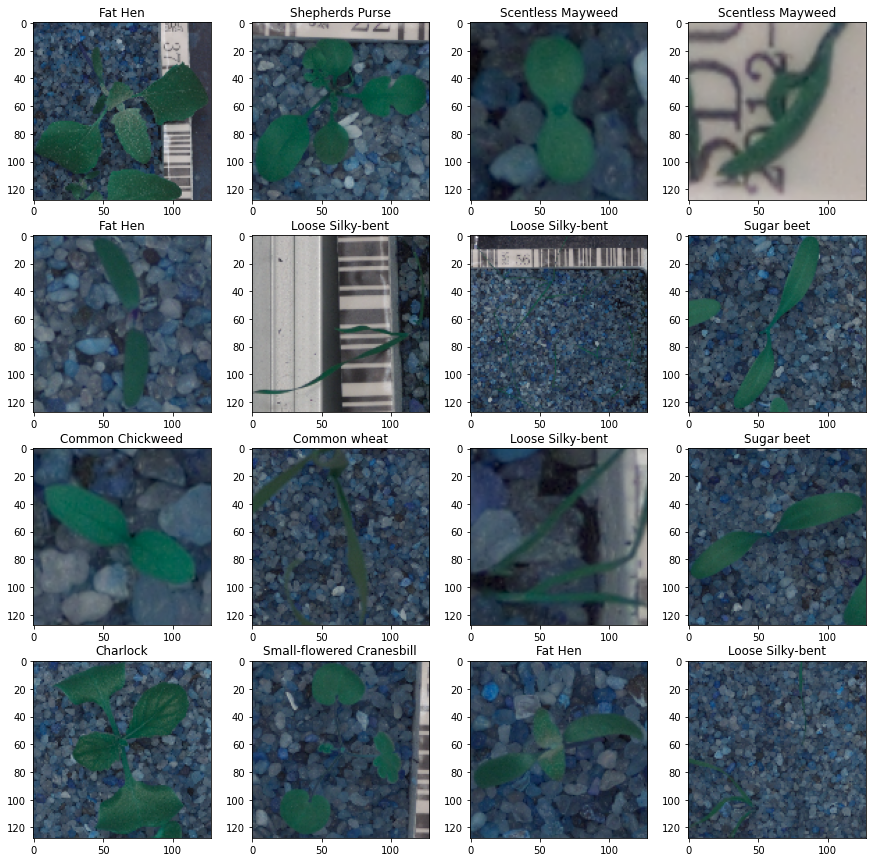

In [6]:
# Plot of images with labels
plot_images(images,labels)

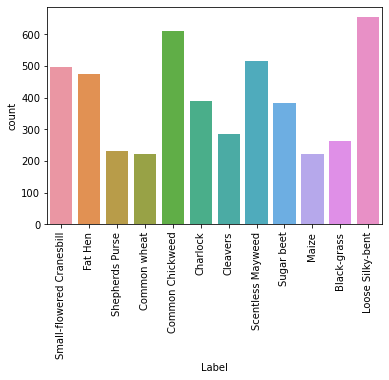

In [7]:
 # Countplot for each category
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical');

- As you can see from the above plot, the dataset is quite imbalanced.
- There are between 200-650 images in each category

### Resizing image size from 128 to 64

In [8]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))
images64=np.array(images_decreased)

In [9]:
# Shape of the decreased image size(128 to 64)
images64.shape

(4750, 64, 64, 3)

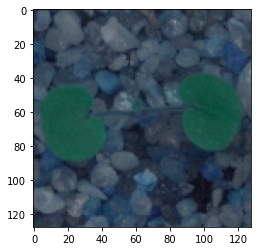

In [10]:
# plot of the original image size(128,128)
plt.imshow(images[0]);

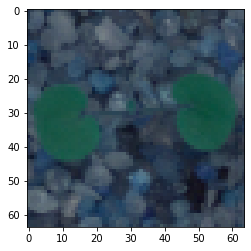

In [11]:
# plot of the decreased image size (64,64)
plt.imshow(images64[0]);

## Visualizing images using Gaussian Blur 

In [12]:
# Applying Gaussian Blur to denoise the images
images_glur=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_glur.append(cv2.GaussianBlur(images64[i], ksize =(3,3),sigmaX =  0))
images_gb=np.array(images_glur)

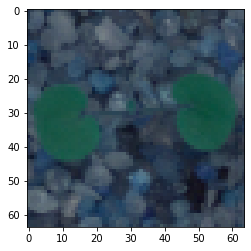

In [13]:
# plot of the decreased image size
plt.imshow(images64[0]);

##  Splitting the dataset

In [14]:
# Split the data into train, val and test dataset
X_train, X_test, y_train, y_test = train_test_split(images_gb, labels , test_size=0.1, random_state=1,stratify=labels)

In [15]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4275, 64, 64, 3) (4275, 1)
(475, 64, 64, 3) (475, 1)


In [16]:
# Calculate the class weights for each label
from sklearn.utils import class_weight

labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.7987668161434978,
 1: 0.8343091334894613,
 2: 1.7127403846153846,
 3: 1.7902010050251256,
 4: 0.6477272727272727,
 5: 1.014957264957265,
 6: 1.380813953488372,
 7: 0.7677801724137931,
 8: 1.026657060518732,
 9: 1.7902010050251256,
 10: 1.5031645569620253,
 11: 0.6048387096774194}

## Encoding the target labels

In [17]:
# Convert labels from names to one hot vectors.
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_test_encoded=enc.transform(y_test)

In [18]:
# Printing the of y_train_encoded and y_test_encoded
print(y_train_encoded.shape)
print(y_test_encoded.shape)

(4275, 12)
(475, 12)


## Data Normalization

In [19]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

# Model Building - Convolutional Neural Network (CNN)

## Model 1

In [20]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [21]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [22]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

### Fitting the model on the train data

In [23]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_split=0.1,
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 10s - loss: 2.4461 - accuracy: 0.1331 - val_loss: 2.3303 - val_accuracy: 0.2617 - 10s/epoch - 81ms/step
Epoch 2/30
121/121 - 9s - loss: 2.2929 - accuracy: 0.2126 - val_loss: 2.1095 - val_accuracy: 0.3131 - 9s/epoch - 72ms/step
Epoch 3/30
121/121 - 9s - loss: 2.1090 - accuracy: 0.2748 - val_loss: 1.9077 - val_accuracy: 0.3832 - 9s/epoch - 73ms/step
Epoch 4/30
121/121 - 9s - loss: 1.9620 - accuracy: 0.3135 - val_loss: 1.7194 - val_accuracy: 0.4065 - 9s/epoch - 73ms/step
Epoch 5/30
121/121 - 9s - loss: 1.8544 - accuracy: 0.3436 - val_loss: 1.6062 - val_accuracy: 0.4673 - 9s/epoch - 74ms/step
Epoch 6/30
121/121 - 9s - loss: 1.7979 - accuracy: 0.3561 - val_loss: 1.6277 - val_accuracy: 0.4813 - 9s/epoch - 77ms/step
Epoch 7/30
121/121 - 9s - loss: 1.7088 - accuracy: 0.3795 - val_loss: 1.4621 - val_accuracy: 0.4930 - 9s/epoch - 78ms/step
Epoch 8/30
121/121 - 9s - loss: 1.6792 - accuracy: 0.3876 - val_loss: 1.5123 - val_accuracy: 0.5070 - 9s/epoch - 74ms/step
Epoch 9/30
121

### Model Evaluation

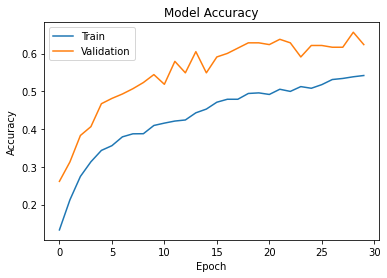

In [24]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 


*   We can see from the above plot that **the validation accuracy of the model is more than the training accuracy.  **
*   The model seems not to be overfitting.

### **Evaluating the model on test data**

In [25]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.1492 - accuracy: 0.6168 - 474ms/epoch - 32ms/step


In [26]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)
y_pred

array([[1.6376336e-05, 9.3855522e-07, 9.8271979e-05, ..., 2.6778991e-05,
        9.5189184e-01, 3.5132829e-02],
       [1.2213615e-10, 8.8227230e-01, 7.0681395e-05, ..., 2.4165064e-02,
        8.7453105e-02, 2.0795332e-03],
       [7.2353534e-05, 4.9139629e-04, 8.3385622e-03, ..., 1.6761487e-02,
        1.6761711e-01, 2.3418345e-01],
       ...,
       [6.6994995e-05, 4.8460743e-01, 2.2359665e-01, ..., 5.4443829e-02,
        1.0005007e-02, 3.3597544e-02],
       [3.7933656e-17, 6.5363139e-08, 8.9757307e-10, ..., 1.0807551e-01,
        5.1157987e-03, 1.7911268e-03],
       [7.6496729e-04, 8.9198411e-02, 2.5813982e-01, ..., 7.5763308e-02,
        1.6571069e-02, 1.2732342e-01]], dtype=float32)

### Plotting the Confusion Matrix

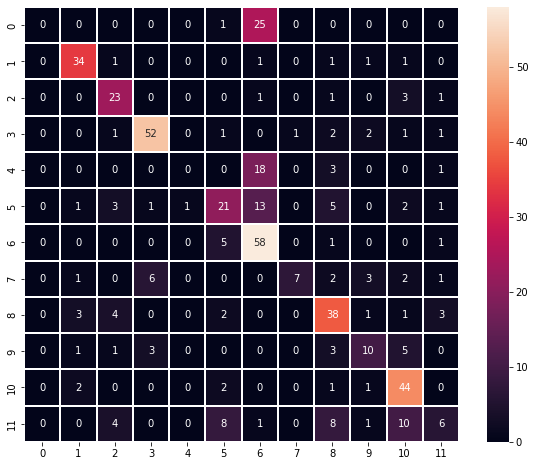

In [27]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly. 
- In comparison to the rest, we can see that classes 1,2,3,5,7,8,9 are well classified.
- We can also observe that classes 0,4 and 6 are mostly misclassified.

## Model 2

In [28]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [29]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [30]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(100, activation='relu'))

# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

### Fitting the model on the train data

In [31]:
history_2 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_split=0.1,
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 11s - loss: 2.4308 - accuracy: 0.1362 - val_loss: 2.3810 - val_accuracy: 0.1355 - 11s/epoch - 94ms/step
Epoch 2/30
121/121 - 10s - loss: 2.2766 - accuracy: 0.2067 - val_loss: 1.9822 - val_accuracy: 0.3715 - 10s/epoch - 82ms/step
Epoch 3/30
121/121 - 10s - loss: 1.6733 - accuracy: 0.4086 - val_loss: 1.4957 - val_accuracy: 0.5070 - 10s/epoch - 84ms/step
Epoch 4/30
121/121 - 10s - loss: 1.4036 - accuracy: 0.5043 - val_loss: 1.3157 - val_accuracy: 0.5748 - 10s/epoch - 80ms/step
Epoch 5/30
121/121 - 10s - loss: 1.1586 - accuracy: 0.5880 - val_loss: 1.1615 - val_accuracy: 0.6449 - 10s/epoch - 84ms/step
Epoch 6/30
121/121 - 10s - loss: 0.9629 - accuracy: 0.6597 - val_loss: 1.2161 - val_accuracy: 0.6425 - 10s/epoch - 82ms/step
Epoch 7/30
121/121 - 10s - loss: 0.8511 - accuracy: 0.7076 - val_loss: 0.9219 - val_accuracy: 0.7290 - 10s/epoch - 81ms/step
Epoch 8/30
121/121 - 10s - loss: 0.7350 - accuracy: 0.7424 - val_loss: 0.9068 - val_accuracy: 0.7523 - 10s/epoch - 83ms/step


### Model Evaluation

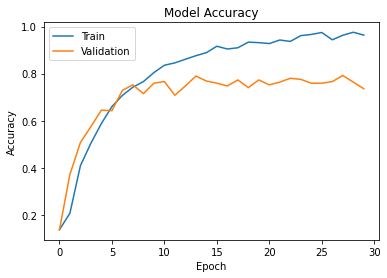

In [32]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 


*   We can see from the above plot that **the training accuracy of the model is more than the validation accuracy.  **
*   The model seems to be overfitting.

### **Evaluating the model on test data**

In [33]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.4037 - accuracy: 0.7326 - 422ms/epoch - 28ms/step


In [34]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)
y_pred

array([[7.0260903e-08, 6.6738494e-08, 2.3278149e-03, ..., 3.1561406e-06,
        6.9347817e-01, 1.8924035e-04],
       [2.2592192e-11, 2.8081033e-02, 2.8483174e-04, ..., 2.1591642e-08,
        9.7114986e-01, 4.8424071e-04],
       [4.2916369e-12, 1.5992416e-12, 5.4512657e-12, ..., 6.2493446e-09,
        2.5578593e-11, 5.0457677e-10],
       ...,
       [8.1277571e-09, 9.9999833e-01, 3.5647275e-08, ..., 1.2825673e-07,
        6.5107031e-08, 1.3759053e-06],
       [5.8132460e-19, 1.1958969e-10, 9.4599271e-22, ..., 5.3519905e-01,
        3.7720253e-07, 1.2834679e-06],
       [3.8330954e-02, 1.2893492e-04, 1.3143331e-03, ..., 8.3609528e-05,
        3.6910046e-07, 2.5894690e-01]], dtype=float32)

### Plotting the Confusion Matrix

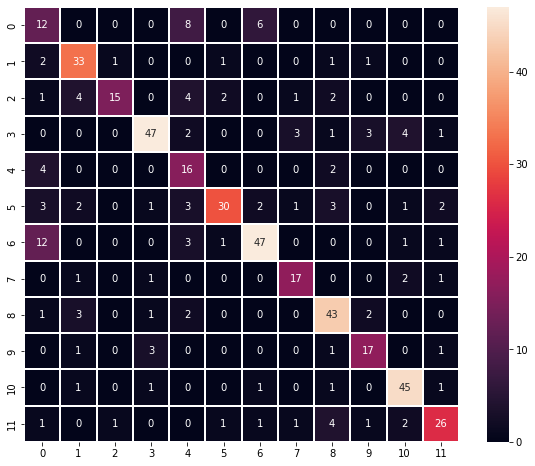

In [35]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly, but most where. 
- In comparison to the rest, we can see that classes 1,2,3,4,5,7,8,9,10,11 are well classified.
- We can also observe that classes 0 and 6 are misclassified.

## Model 3 "Accuracy"

**As we see model 2 appears to overfit the train set. Therefore we'll try to address this problem with Batch Normalization and Dropout to check if we can improve the model's performance.**

## **Batch Normalization and Dropout**

In [36]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [37]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [38]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
#model.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.1))
          
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

### Fitting the model on the train data

In [39]:
history_3 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_split=0.1,
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 11s - loss: 1.6544 - accuracy: 0.4276 - val_loss: 3.1172 - val_accuracy: 0.1612 - 11s/epoch - 87ms/step
Epoch 2/30
121/121 - 11s - loss: 1.1709 - accuracy: 0.5971 - val_loss: 4.5431 - val_accuracy: 0.1495 - 11s/epoch - 88ms/step
Epoch 3/30
121/121 - 10s - loss: 0.8736 - accuracy: 0.7068 - val_loss: 2.3722 - val_accuracy: 0.3902 - 10s/epoch - 86ms/step
Epoch 4/30
121/121 - 10s - loss: 0.7236 - accuracy: 0.7562 - val_loss: 5.7702 - val_accuracy: 0.1963 - 10s/epoch - 84ms/step
Epoch 5/30
121/121 - 10s - loss: 0.5745 - accuracy: 0.8009 - val_loss: 3.1451 - val_accuracy: 0.4065 - 10s/epoch - 84ms/step
Epoch 6/30
121/121 - 10s - loss: 0.4793 - accuracy: 0.8323 - val_loss: 1.7077 - val_accuracy: 0.5654 - 10s/epoch - 83ms/step
Epoch 7/30
121/121 - 10s - loss: 0.4198 - accuracy: 0.8505 - val_loss: 1.6293 - val_accuracy: 0.6215 - 10s/epoch - 81ms/step
Epoch 8/30
121/121 - 10s - loss: 0.3257 - accuracy: 0.8783 - val_loss: 1.0447 - val_accuracy: 0.7453 - 10s/epoch - 84ms/step


### Model Evaluation

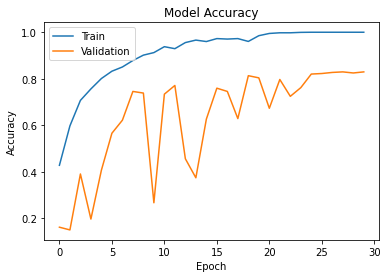

In [40]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 


*   We can see from the above plot that **the training accuracy of the model is more than the validation accuracy.  **
*   The model seems to be overfitting.
*   Model is 100% accuracy on training dataset and 83% on validation accuracy

### **Evaluating the model on test data**

In [41]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.4898 - accuracy: 0.7916 - 408ms/epoch - 27ms/step


In [42]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)
y_pred

array([[1.04919984e-09, 1.43860423e-12, 1.66580749e-09, ...,
        4.08821231e-14, 9.42873597e-01, 1.77841112e-02],
       [8.45768104e-21, 1.23684597e-03, 1.01241994e-05, ...,
        1.43808325e-08, 9.98753071e-01, 4.87054268e-16],
       [8.96480969e-14, 6.66257005e-16, 6.95822436e-12, ...,
        1.33120792e-09, 8.34566194e-13, 1.42934609e-10],
       ...,
       [2.49791132e-10, 9.99997497e-01, 2.09494829e-06, ...,
        2.32296523e-13, 1.44822820e-09, 3.30702619e-07],
       [5.41547647e-23, 3.17824150e-24, 1.52119204e-28, ...,
        4.99819934e-12, 4.19959101e-18, 1.45813103e-12],
       [6.06506703e-08, 4.48385923e-04, 3.73255345e-04, ...,
        5.18526140e-05, 4.00383143e-10, 9.99016523e-01]], dtype=float32)

### Plotting the Confusion Matrix

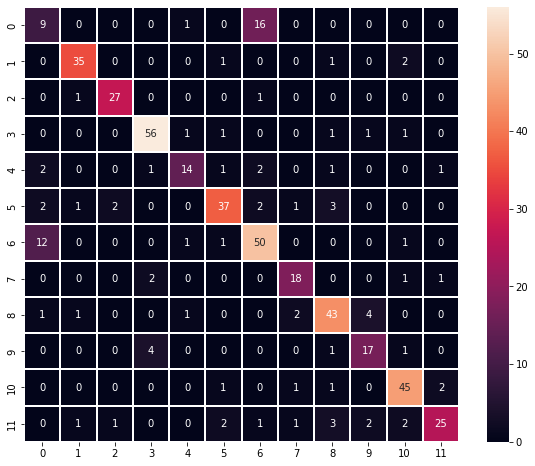

In [43]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly, but most where. 
- In comparison to the rest, we can see that classes 1,2,3,4,5,7,8,9,10,11 are well classified.
- We can also observe that classes 0 and 6 are misclassified.

## Model 4 "Recall"

In [45]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [46]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [47]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
#model.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.1))
          
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall()])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

### Fitting the model on the train data

In [48]:
history_4 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_split=0.1,
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 11s - loss: 1.6544 - recall: 0.2339 - val_loss: 3.1172 - val_recall: 0.1425 - 11s/epoch - 89ms/step
Epoch 2/30
121/121 - 10s - loss: 1.1709 - recall: 0.4502 - val_loss: 4.5431 - val_recall: 0.1262 - 10s/epoch - 82ms/step
Epoch 3/30
121/121 - 10s - loss: 0.8736 - recall: 0.6140 - val_loss: 2.3722 - val_recall: 0.3364 - 10s/epoch - 84ms/step
Epoch 4/30
121/121 - 10s - loss: 0.7236 - recall: 0.6899 - val_loss: 5.7702 - val_recall: 0.1916 - 10s/epoch - 83ms/step
Epoch 5/30
121/121 - 10s - loss: 0.5745 - recall: 0.7546 - val_loss: 3.1451 - val_recall: 0.3949 - 10s/epoch - 85ms/step
Epoch 6/30
121/121 - 10s - loss: 0.4793 - recall: 0.7970 - val_loss: 1.7077 - val_recall: 0.5374 - 10s/epoch - 85ms/step
Epoch 7/30
121/121 - 10s - loss: 0.4198 - recall: 0.8232 - val_loss: 1.6293 - val_recall: 0.5981 - 10s/epoch - 86ms/step
Epoch 8/30
121/121 - 11s - loss: 0.3257 - recall: 0.8557 - val_loss: 1.0447 - val_recall: 0.7243 - 11s/epoch - 88ms/step
Epoch 9/30
121/121 - 10s - loss:

### Model Evaluation

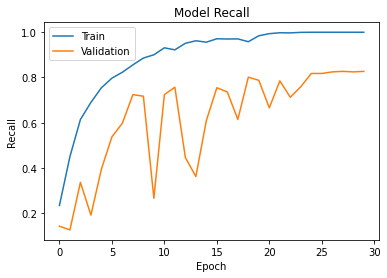

In [67]:
plt.plot(history_4.history['recall'])
plt.plot(history_4.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 


*   We can see from the above plot that **the training precision of the model is more than the validation precision.  **
*   The model seems to be overfitting.
*   Model is 100% precision on training dataset and 83% on validation precision

### **Evaluating the model on test data**

In [51]:
recall = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.4898 - recall: 0.7916 - 379ms/epoch - 25ms/step


In [52]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)
y_pred

array([[1.04919984e-09, 1.43860423e-12, 1.66580749e-09, ...,
        4.08821231e-14, 9.42873597e-01, 1.77841112e-02],
       [8.45768104e-21, 1.23684597e-03, 1.01241994e-05, ...,
        1.43808325e-08, 9.98753071e-01, 4.87054268e-16],
       [8.96480969e-14, 6.66257005e-16, 6.95822436e-12, ...,
        1.33120792e-09, 8.34566194e-13, 1.42934609e-10],
       ...,
       [2.49791132e-10, 9.99997497e-01, 2.09494829e-06, ...,
        2.32296523e-13, 1.44822820e-09, 3.30702619e-07],
       [5.41547647e-23, 3.17824150e-24, 1.52119204e-28, ...,
        4.99819934e-12, 4.19959101e-18, 1.45813103e-12],
       [6.06506703e-08, 4.48385923e-04, 3.73255345e-04, ...,
        5.18526140e-05, 4.00383143e-10, 9.99016523e-01]], dtype=float32)

### Plotting the Confusion Matrix

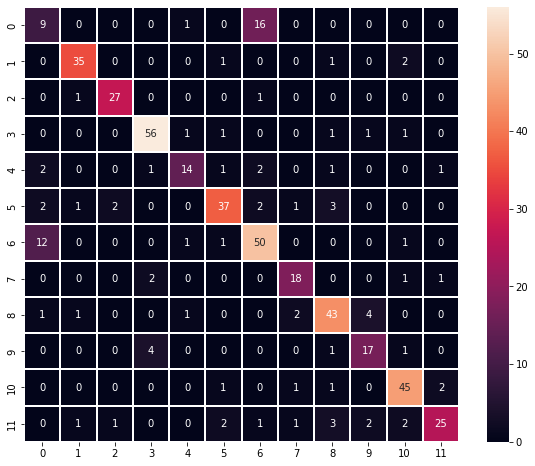

In [53]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly, but most where. 
- In comparison to the rest, we can see that classes 1,2,3,4,5,7,8,9,10,11 are well classified.
- We can also observe that classes 0 and 6 are misclassified.

## Model 5 "Precision"

In [63]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [64]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [65]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
#model.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.1))
          
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision()])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

### Fitting the model on the train data

In [66]:
history_5 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_split=0.1,
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 11s - loss: 1.6544 - precision: 0.6479 - val_loss: 3.1172 - val_precision: 0.1832 - 11s/epoch - 92ms/step
Epoch 2/30
121/121 - 10s - loss: 1.1709 - precision: 0.7145 - val_loss: 4.5431 - val_precision: 0.1742 - 10s/epoch - 80ms/step
Epoch 3/30
121/121 - 10s - loss: 0.8736 - precision: 0.7916 - val_loss: 2.3722 - val_precision: 0.4966 - 10s/epoch - 84ms/step
Epoch 4/30
121/121 - 10s - loss: 0.7236 - precision: 0.8179 - val_loss: 5.7702 - val_precision: 0.2147 - 10s/epoch - 86ms/step
Epoch 5/30
121/121 - 10s - loss: 0.5745 - precision: 0.8503 - val_loss: 3.1451 - val_precision: 0.4102 - 10s/epoch - 83ms/step
Epoch 6/30
121/121 - 10s - loss: 0.4793 - precision: 0.8738 - val_loss: 1.7077 - val_precision: 0.6005 - 10s/epoch - 86ms/step
Epoch 7/30
121/121 - 10s - loss: 0.4198 - precision: 0.8817 - val_loss: 1.6293 - val_precision: 0.6497 - 10s/epoch - 82ms/step
Epoch 8/30
121/121 - 10s - loss: 0.3257 - precision: 0.8987 - val_loss: 1.0447 - val_precision: 0.7692 - 10s/ep

### Model Evaluation

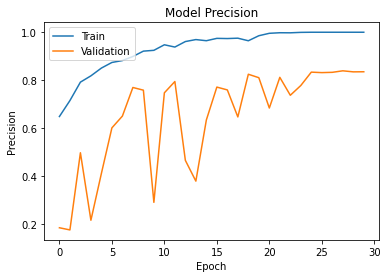

In [69]:
plt.plot(history_5.history['precision'])
plt.plot(history_5.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 


*   We can see from the above plot that **the training recall of the model is more than the validation recall.  **
*   The model seems to be overfitting.
*   Model is 100% recall on training dataset and 83% on validation recall

### **Evaluating the model on test data**

In [70]:
precision = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.4898 - precision: 0.7949 - 418ms/epoch - 28ms/step


In [71]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)
y_pred

array([[1.04919984e-09, 1.43860423e-12, 1.66580749e-09, ...,
        4.08821231e-14, 9.42873597e-01, 1.77841112e-02],
       [8.45768104e-21, 1.23684597e-03, 1.01241994e-05, ...,
        1.43808325e-08, 9.98753071e-01, 4.87054268e-16],
       [8.96480969e-14, 6.66257005e-16, 6.95822436e-12, ...,
        1.33120792e-09, 8.34566194e-13, 1.42934609e-10],
       ...,
       [2.49791132e-10, 9.99997497e-01, 2.09494829e-06, ...,
        2.32296523e-13, 1.44822820e-09, 3.30702619e-07],
       [5.41547647e-23, 3.17824150e-24, 1.52119204e-28, ...,
        4.99819934e-12, 4.19959101e-18, 1.45813103e-12],
       [6.06506703e-08, 4.48385923e-04, 3.73255345e-04, ...,
        5.18526140e-05, 4.00383143e-10, 9.99016523e-01]], dtype=float32)

### Plotting the Confusion Matrix

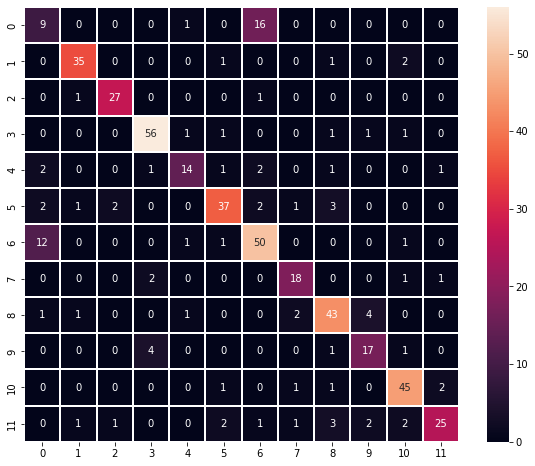

In [72]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly, but most where. 
- In comparison to the rest, we can see that classes 1,2,3,4,5,7,8,9,10,11 are well classified.
- We can also observe that classes 0 and 6 are misclassified.

# Conclusion and key takeaways

- We can observe from the confusion matrix of all the models that our model 3 was the best model because it predicted the majority of the classes better than the other models.
- The test accuracy of model 3 is 79.16%
- The test recall of model 4 is 79.16%
- The test precision of model 5 is 79.49%
- Batch Normalization and Dropout is what helped in improving the model.
- Class 0 and class 6 are the two classes where most of the mistakes happened, improvements in the two classes will improve overall accuracy
- "Small-flowered Cranesbill" and "Cleavers" are the two plants with missclassifications
- These models can be further improved by training with different filter sizes and different number of filters. 
- These models can also be trained on the original image_size (128,128,3) rather than being reduced to 64 for better results.
- Data Augmentation can also be performed to improve the model performance.
- More images especially in class 0 and class 6 will also help improve the predictions of the model.